# Caollect Data and Train Gaussian Processes

## Setup and imports

In [3]:
# ===============================================
# 1️⃣ Setup e imports
# ===============================================
import mujoco as mj
from mujoco.glfw import glfw
import numpy as np
import time, os
from tqdm import tqdm
import matplotlib.pyplot as plt

from models.cantilever_2d_drone import get_xml  # tu generador XML

# Configuración base de MuJoCo
XML = get_xml(num_segmentos=8, longitud_total=0.6)
model = mj.MjModel.from_xml_string(XML)
data = mj.MjData(model)

# Función para hacer un paso en la simulación
def step_sim(data, ctrl):
    data.ctrl[:] = ctrl
    mj.mj_step(model, data)
    return np.array([
        data.sensor("pos_drone").data[0],   # x
        data.sensor("pos_drone").data[2],   # z
        data.qvel[0],                       # x'
        data.qvel[2],                       # z'
        data.qpos[1],                       # θ (asumiendo 2° DoF rotacional)
        data.qvel[1],                       # θ'
    ])

print("✅ Simulador inicializado correctamente.")


✅ Simulador inicializado correctamente.


## Data collection

In [4]:
# ===============================================
# 2️⃣ Recolección de datos del simulador
# ===============================================

def rollout_random(model, data, n_steps=10000, dt=0.01):
    mj.mj_resetData(model, data)
    mj.mj_forward(model, data)
    
    states, actions, next_states = [], [], []
    
    for _ in tqdm(range(n_steps)):
        s_t = np.array([
            data.sensor("pos_drone").data[0],
            data.sensor("pos_drone").data[2],
            data.qvel[0],
            data.qvel[2],
            data.qpos[1],
            data.qvel[1],
        ])
        
        # acción aleatoria: empujes entre [0, 2] N
        a_t = np.random.uniform(0.2, 1.8, size=2)
        data.ctrl[:] = a_t
        
        mj.mj_step(model, data)
        
        s_next = np.array([
            data.sensor("pos_drone").data[0],
            data.sensor("pos_drone").data[2],
            data.qvel[0],
            data.qvel[2],
            data.qpos[1],
            data.qvel[1],
        ])
        
        states.append(s_t)
        actions.append(a_t)
        next_states.append(s_next)
    
    return np.array(states), np.array(actions), np.array(next_states)

# Ejecutar recolección
states, actions, next_states = rollout_random(model, data, n_steps=2000)

# Guardar diferencias (delta_s)
delta_s = next_states - states

print("✅ Datos recolectados:", states.shape, actions.shape, delta_s.shape)


100%|██████████| 2000/2000 [00:00<00:00, 32108.52it/s]

✅ Datos recolectados: (2000, 6) (2000, 2) (2000, 6)


## Gaussian Process Training

In [5]:
# ===============================================
# 3️⃣ Entrenamiento o carga del modelo GP
# ===============================================
import os, joblib
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

# Crear carpeta si no existe
os.makedirs("data/gp_models", exist_ok=True)

# Archivos donde se guardarán los modelos
model_paths = [f"data/gp_models/gp_model_{i}.pkl" for i in range(6)]

# Entradas = estado + acción
X = np.hstack([states, actions])
Y = delta_s

# Kernel compartido
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5, 1e-1))

gps = []
all_exist = all(os.path.exists(p) for p in model_paths)

if all_exist:
    print("📂 Cargando modelos GP guardados...")
    for path in model_paths:
        gps.append(joblib.load(path))
    print("✅ Modelos cargados correctamente.")
else:
    print("⚙️ Entrenando nuevos modelos Gaussian Process...")
    for i in tqdm(range(Y.shape[1])):
        gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=2)
        gp.fit(X, Y[:, i])
        gps.append(gp)
        joblib.dump(gp, model_paths[i])
    print("✅ Entrenamiento y guardado completo.")


📂 Cargando modelos GP guardados...
✅ Modelos cargados correctamente.


## Validation and Visualization

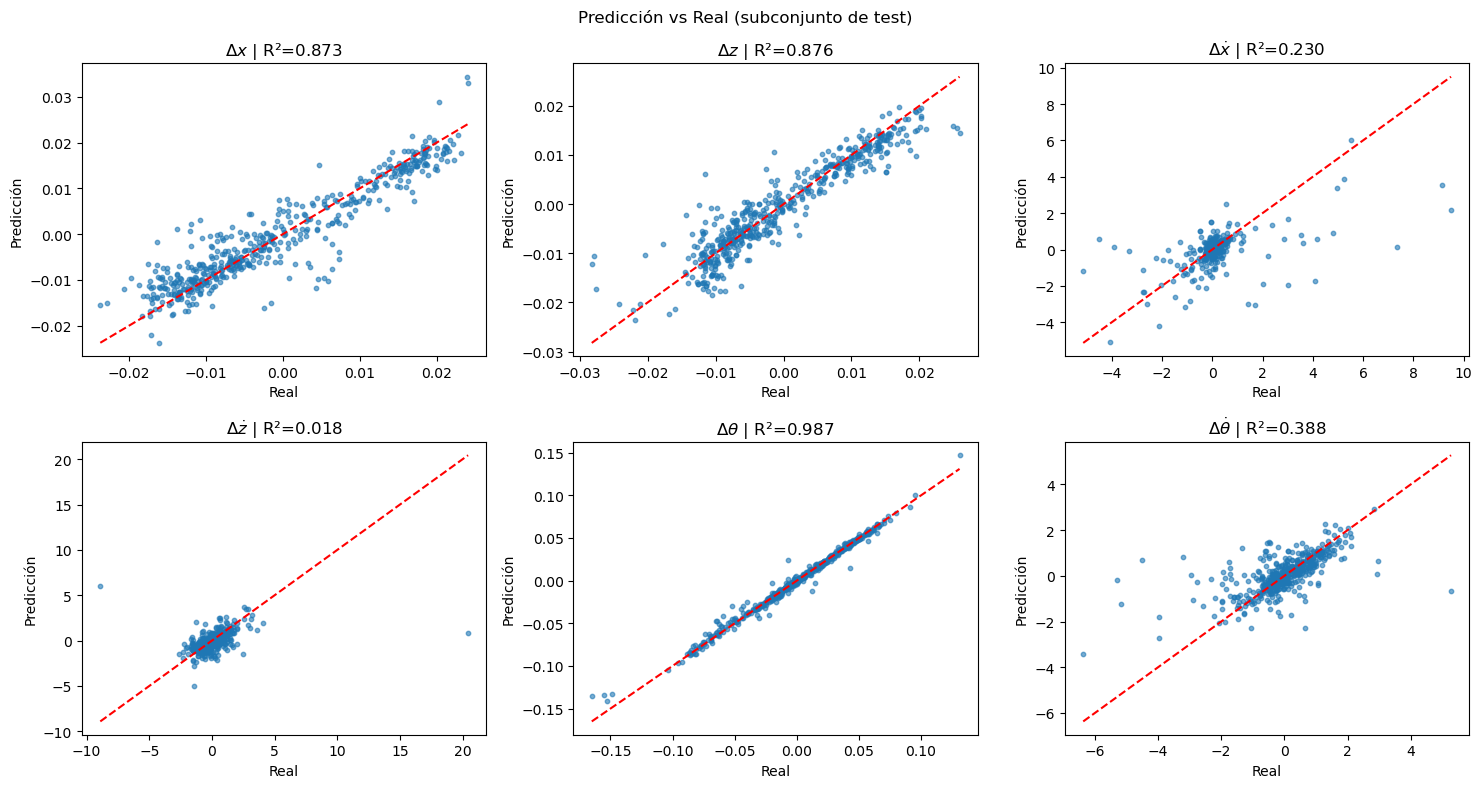

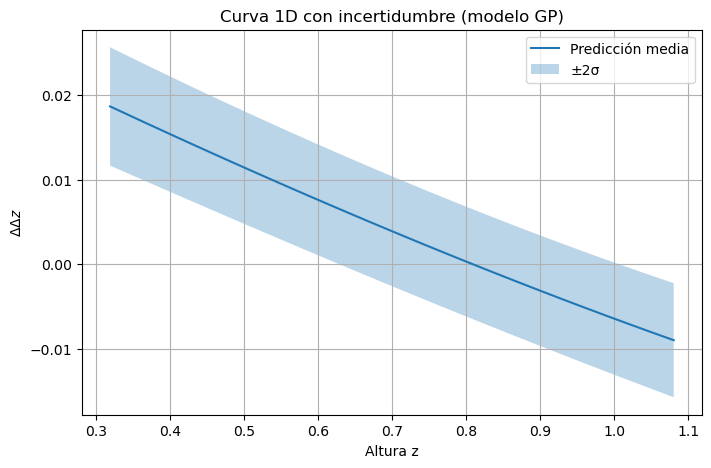

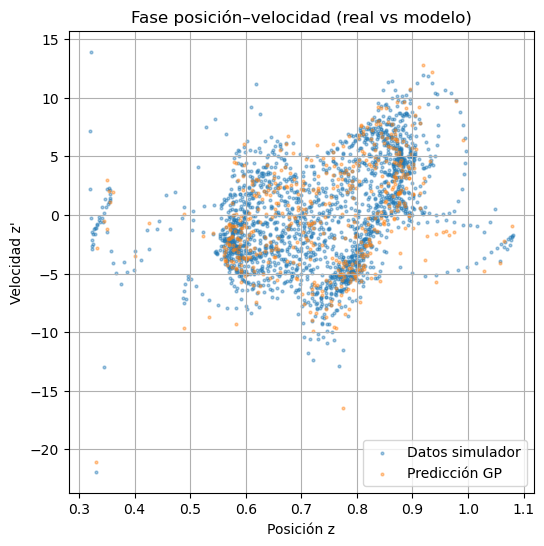

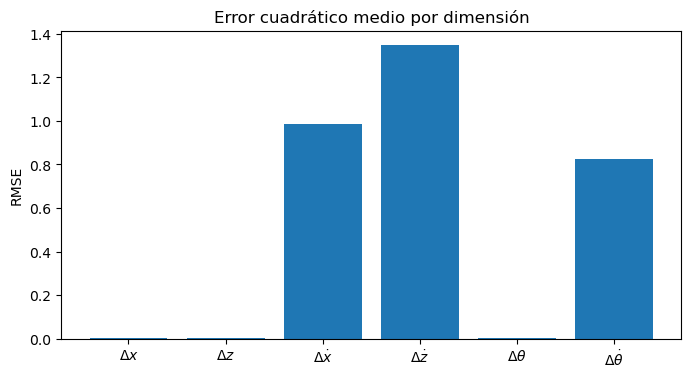

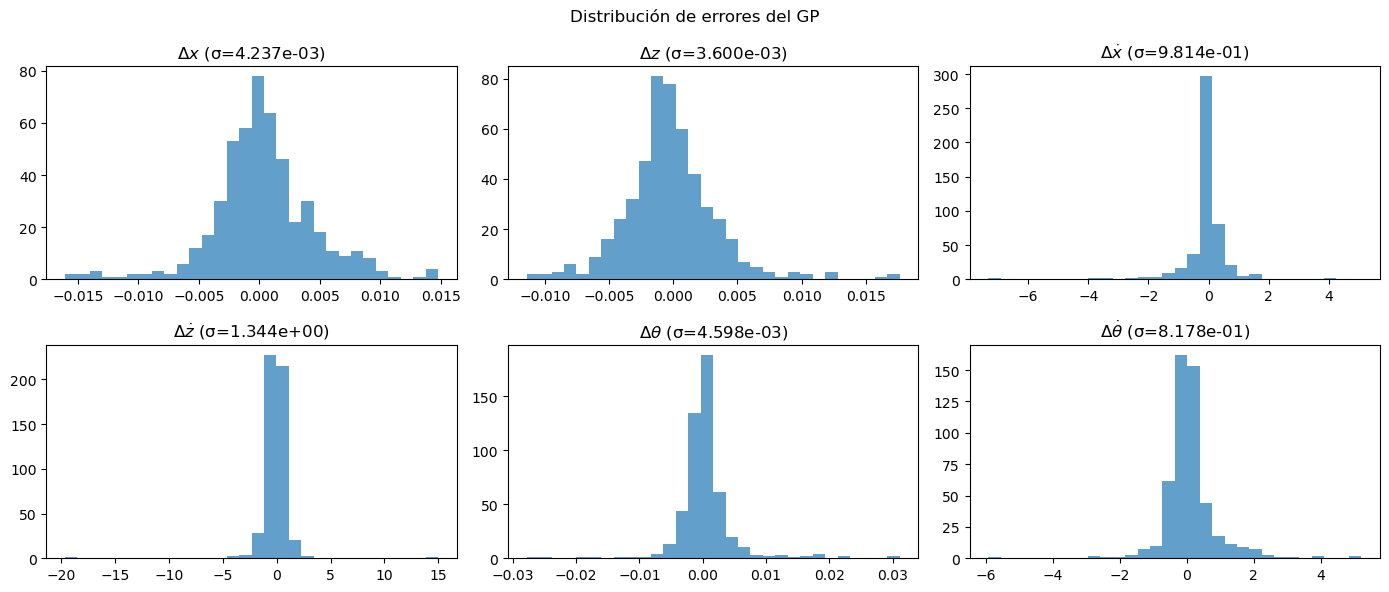

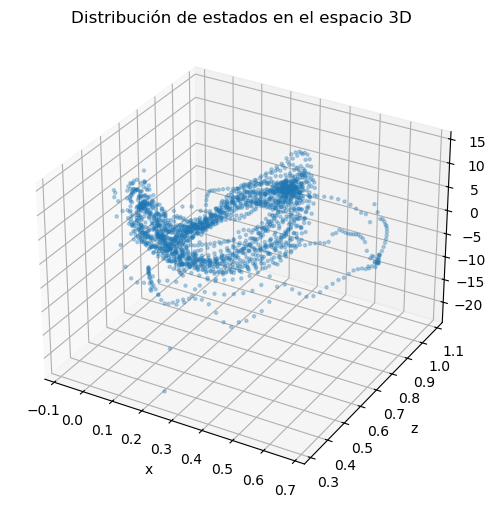

In [6]:
# ===============================================
# 4️⃣ Diagnóstico y visualización del modelo GP
# ===============================================
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Recalcular predicciones sobre un subconjunto de datos
idx = np.random.choice(len(X), size=500, replace=False)
X_test, Y_true = X[idx], Y[idx]
Y_pred = np.zeros_like(Y_true)

# Predicciones por modelo
for i in range(Y_true.shape[1]):
    Y_pred[:, i] = gps[i].predict(X_test)

# --------------------------
# 1️⃣ Scatter: Pred vs Real
# --------------------------
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
labels = [r'$\Delta x$', r'$\Delta z$', r'$\Delta \dot{x}$', r'$\Delta \dot{z}$', r'$\Delta \theta$', r'$\Delta \dot{\theta}$']

for i, ax in enumerate(axes.flat):
    ax.scatter(Y_true[:, i], Y_pred[:, i], s=10, alpha=0.6)
    ax.plot([Y_true[:, i].min(), Y_true[:, i].max()],
            [Y_true[:, i].min(), Y_true[:, i].max()], 'r--')
    ax.set_title(f"{labels[i]} | R²={r2_score(Y_true[:, i], Y_pred[:, i]):.3f}")
    ax.set_xlabel("Real")
    ax.set_ylabel("Predicción")

plt.suptitle("Predicción vs Real (subconjunto de test)")
plt.tight_layout()
plt.show()

# --------------------------
# 2️⃣ Curva 1D con incertidumbre
# --------------------------
# Elegimos una variable y analizamos su dependencia con z (altura)
var_idx = 1  # Ejemplo: delta z
dim = 1      # Analizamos dependencia con z

# Barrido de una variable (z) manteniendo el resto fijo
z_values = np.linspace(X[:, dim].min(), X[:, dim].max(), 100)
X_base = np.mean(X, axis=0)
X_curve = np.tile(X_base, (100, 1))
X_curve[:, dim] = z_values

# Predicción con incertidumbre
y_mean, y_std = gps[var_idx].predict(X_curve, return_std=True)

plt.figure(figsize=(8,5))
plt.plot(z_values, y_mean, label='Predicción media')
plt.fill_between(z_values, y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.3, label='±2σ')
plt.xlabel("Altura z")
plt.ylabel(f"Δ{labels[var_idx]}")
plt.title("Curva 1D con incertidumbre (modelo GP)")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# 3️⃣ Fase: posición vs velocidad (modelo vs datos)
# --------------------------
plt.figure(figsize=(6,6))
plt.scatter(states[:,1], states[:,3], s=4, alpha=0.4, label="Datos simulador")
plt.scatter(states[idx,1], states[idx,3]+Y_pred[:,3], s=4, alpha=0.4, label="Predicción GP")
plt.xlabel("Posición z")
plt.ylabel("Velocidad z'")
plt.title("Fase posición–velocidad (real vs modelo)")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# 4️⃣ Errores por variable
# --------------------------
errors = Y_pred - Y_true
rmse = np.sqrt(np.mean(errors**2, axis=0))

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(range(6), rmse)
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_ylabel("RMSE")
ax.set_title("Error cuadrático medio por dimensión")
plt.show()

# Distribución de error (histogramas)
fig, axes = plt.subplots(2,3, figsize=(14,6))
for i, ax in enumerate(axes.flat):
    ax.hist(errors[:,i], bins=30, alpha=0.7)
    ax.set_title(f"{labels[i]} (σ={np.std(errors[:,i]):.3e})")
plt.suptitle("Distribución de errores del GP")
plt.tight_layout()
plt.show()



from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(states[:,0], states[:,1], states[:,3], s=5, alpha=0.3)
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_zlabel("z'")
ax.set_title("Distribución de estados en el espacio 3D")
plt.show()


#  MPPI Controller

In [20]:
# ===============================================
# 5️⃣ Controlador MPPI basado en modelo GP
# ===============================================
import numpy as np

# -----------------------------------
# 1. Parámetros del MPPI
# -----------------------------------
H = 15             # horizonte (pasos de predicción)
N = 50            # número de rollouts (muestras)
lambda_ = 1.0      # temperatura del MPPI
sigma_u = 0.2      # desviación estándar del ruido de acción
dt = 0.01
u_init = np.array([1.0, 1.0])   # acción nominal (hover)

# -----------------------------------
# 2. Función de costo
# -----------------------------------
def cost_function(
    s, a,
    goal=np.array([0.0, 1.0, 0, 0, 0, 0]),
    weights=None
):
    """
    Penaliza errores en posición, velocidad, ángulo y control.
    Permite calibrar pesos por eje: x, z y theta.

    s = [x, z, x_dot, z_dot, theta, theta_dot]
    a = [u1, u2]
    """
    # --- pesos por defecto ---
    if weights is None:
        weights = dict(
            x_pos=1.0,
            z_pos=3.0,
            x_vel=0.5,
            z_vel=1.0,
            theta=2.0,
            theta_dot=1.0,
            ctrl_effort=0.1,
            ctrl_asym=0.05,
        )

    # --- errores individuales ---
    x_err = s[0] - goal[0]           # desplazamiento horizontal
    z_err = s[1] - goal[1]           # altura
    x_vel_err = s[2]                 # velocidad en x
    z_vel_err = s[3]                 # velocidad en z
    theta_err = s[4]                 # inclinación
    theta_dot_err = s[5]             # velocidad angular
    ctrl_effort = np.linalg.norm(a - np.array([1.0, 1.0]))  # desviación respecto al hover
    ctrl_asym = np.abs(a[0] - a[1])  # diferencia entre hélices

    # --- costo total ---
    cost = (
        weights["x_pos"] * (x_err ** 2)
        + weights["z_pos"] * (z_err ** 2)
        + weights["x_vel"] * (x_vel_err ** 2)
        + weights["z_vel"] * (z_vel_err ** 2)
        + weights["theta"] * (theta_err ** 2)
        + weights["theta_dot"] * (theta_dot_err ** 2)
        + weights["ctrl_effort"] * (ctrl_effort ** 2)
        + weights["ctrl_asym"] * (ctrl_asym ** 2)
    )

    return cost


# -----------------------------------
# 4. MPPI Controller
# -----------------------------------
def mppi_control(s0, u_mean, N=50, H=15, lambda_=1.0, sigma_u=0.2):
    """
    Ejecuta un ciclo de optimización MPPI.
    Retorna la acción óptima y la nueva secuencia de control.
    """
    # muestreo de ruido
    noise = np.random.randn(N, H, 2) * sigma_u
    costs = np.zeros(N)
    actions = np.zeros((N, H, 2))

    for n in range(N):
        s = np.copy(s0)
        cost = 0.0
        for t in range(H):
            u_t = np.clip(u_mean[t] + noise[n, t], 0.0, 2.0)
            s = predict_next_gp(s, u_t)
            cost += cost_function(s, u_t)
            actions[n, t] = u_t
        costs[n] = cost

    # pesos de importancia (softmin)
    beta = np.min(costs)
    weights = np.exp(-(costs - beta) / lambda_)
    weights /= np.sum(weights)

    # actualización del control medio
    for t in range(H):
        u_mean[t] = np.sum(weights[:, None] * actions[:, t, :], axis=0)

    return u_mean[0], u_mean  # acción actual y secuencia actualizada


## Sim GP + MPPI

In [22]:
# ===============================================
# 6️⃣ Simulación de control en bucle cerrado
# ===============================================
import matplotlib.pyplot as plt

# Estado inicial
s = np.array([0.2, 0.3, 0, 0, 0.0, 0])
u_mean = np.tile(u_init, (H, 1))
goal = np.array([0.0, 0.8, 0, 0, 0, 0])

# 🔧 Pesos calibrables (por eje)
weights_custom = dict(
    x_pos=0.0, z_pos=3.5,         # posición
    x_vel=0.8, z_vel=1.2,         # velocidad
    theta=0.0, theta_dot=1.0,     # ángulo y velocidad angular
    ctrl_effort=0.1, ctrl_asym=0.05
)

# Duración de simulación
T = 100
traj_s, traj_u, traj_cost = [], [], []

# 🔁 Simulación
for t in tqdm(range(T)):
    # Obtener acción óptima con pesos personalizados
    u, u_mean = mppi_control(s, u_mean)
    
    # Actualizar estado (modelo GP)
    s_next = predict_next_gp(s, u)
    
    # Registrar trayectoria y costo
    traj_s.append(s_next)
    traj_u.append(u)
    traj_cost.append(cost_function(s, u, goal, weights_custom))
    
    s = s_next.copy()

traj_s = np.array(traj_s)
traj_u = np.array(traj_u)
traj_cost = np.array(traj_cost)

# ===============================================
# 7️⃣ Visualización de resultados
# ===============================================
fig, axes = plt.subplots(4, 1, figsize=(8, 12))

# Posición
axes[0].plot(traj_s[:,0], label="x")
axes[0].plot(traj_s[:,1], label="z")
axes[0].axhline(goal[1], color='r', linestyle='--', label="z objetivo")
axes[0].set_ylabel("Posición [m]")
axes[0].legend()
axes[0].grid()

# Ángulo
axes[1].plot(traj_s[:,4], label="θ")
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_ylabel("Ángulo [rad]")
axes[1].legend()
axes[1].grid()

# Control
axes[2].plot(traj_u[:,0], label="u1")
axes[2].plot(traj_u[:,1], label="u2")
axes[2].set_ylabel("Empuje [N]")
axes[2].set_xlabel("Tiempo (pasos)")
axes[2].legend()
axes[2].grid()

# Costo total
axes[3].plot(traj_cost, label="Costo instantáneo")
axes[3].set_ylabel("Costo")
axes[3].set_xlabel("Tiempo (pasos)")
axes[3].legend()
axes[3].grid()

plt.suptitle("Control MPPI con dinámica aprendida (GP) y costo calibrable por eje")
plt.tight_layout()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'predict_next_gp' is not defined

# MPPI with MuJoCo

In [11]:
# ===============================================
# 8️⃣ MPPI + MuJoCo en bucle cerrado
# ===============================================
import mujoco as mj
from mujoco.glfw import glfw
import time

# Reinicia el simulador
XML = get_xml(num_segmentos=8, longitud_total=0.6)
model = mj.MjModel.from_xml_string(XML)
data = mj.MjData(model)

# Configura ventana de render
glfw.init()
window = glfw.create_window(800, 600, "MuJoCo MPPI Control", None, None)
glfw.make_context_current(window)
cam = mj.MjvCamera()
opt = mj.MjvOption()
mj.mjv_defaultCamera(cam)
mj.mjv_defaultOption(opt)
scene = mj.MjvScene(model, maxgeom=10000)
context = mj.MjrContext(model, mj.mjtFontScale.mjFONTSCALE_150.value)

# Estado inicial y buffers
mj.mj_resetData(model, data)
mj.mj_forward(model, data)
traj = []

# Parámetros del MPPI
H = 1
N = 10
lambda_ = 1.0
sigma_u = 0.2
u_init = np.array([1.0, 1.0])
u_mean = np.tile(u_init, (H, 1))
goal = np.array([0.0, 0.8, 0, 0, 0, 0])
sim_steps = 1000

# Helpers
def get_state(data):
    return np.array([
        data.sensor("pos_drone").data[0],
        data.sensor("pos_drone").data[2],
        data.qvel[0],
        data.qvel[2],
        data.qpos[1],
        data.qvel[1],
    ])

def step_sim(data, ctrl):
    data.ctrl[:] = ctrl
    mj.mj_step(model, data)

# Bucle principal
for t in tqdm(range(sim_steps)):
    s = get_state(data)
    u, u_mean = mppi_control(s, u_mean)
    step_sim(data, u)
    traj.append(get_state(data))

    # Render
    viewport = mj.MjrRect(0, 0, *glfw.get_framebuffer_size(window))
    mj.mjv_updateScene(model, data, opt, None, cam, mj.mjtCatBit.mjCAT_ALL.value, scene)
    mj.mjr_render(viewport, scene, context)
    glfw.swap_buffers(window)
    glfw.poll_events()
    time.sleep(0.01)

glfw.terminate()
traj = np.array(traj)
print("✅ Simulación completa.")


100%|██████████| 1000/1000 [01:38<00:00, 10.16it/s]

✅ Simulación completa.


# GPU TORCH Running

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim

class DynamicsNN(nn.Module):
    def __init__(self, in_dim=8, out_dim=6, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, out_dim),
        )
    def forward(self, x):
        return self.net(x)

# Entrenamiento rápido usando los mismos datos X, Y que usaste con el GP
model_dyn = DynamicsNN().to(device)
opt = optim.Adam(model_dyn.parameters(), lr=1e-3)

X_t = torch.tensor(np.hstack([states, actions]), dtype=torch.float32, device=device)
Y_t = torch.tensor(delta_s, dtype=torch.float32, device=device)

for epoch in range(1000):
    pred = model_dyn(X_t)
    loss = torch.mean((pred - Y_t)**2)
    opt.zero_grad(); loss.backward(); opt.step()


In [63]:
def predict_next_nn_batch(s_batch, a_batch):
    """
    s_batch: [N, 6]
    a_batch: [N, 2]
    """
    x = torch.cat([s_batch, a_batch], dim=1)
    delta = model_dyn(x)
    return s_batch + delta


In [64]:
def mppi_control_gpu_nn(s0, u_mean, goal, weights, N=512, lambda_=1.0, sigma_u=0.2):
    H = u_mean.shape[0]
    s0 = torch.tensor(s0, dtype=torch.float32, device=device)
    u_seq = torch.tensor(u_mean, dtype=torch.float32, device=device).unsqueeze(0)
    noise = torch.randn((N, H, 2), device=device) * sigma_u
    u_seq = torch.clamp(u_seq + noise, 0.0, 2.0)

    s = s0.repeat(N, 1)
    costs = torch.zeros(N, device=device)

    for t in range(H):
        a_t = u_seq[:, t, :]
        s = predict_next_nn_batch(s, a_t)  # ✅ ahora en GPU, vectorizado

        # costo vectorizado
        x_err = (s[:,0]-goal[0])**2 * weights["x_pos"]
        z_err = (s[:,1]-goal[1])**2 * weights["z_pos"]
        x_vel = s[:,2]**2 * weights["x_vel"]
        z_vel = s[:,3]**2 * weights["z_vel"]
        theta = s[:,4]**2 * weights["theta"]
        theta_dot = s[:,5]**2 * weights["theta_dot"]
        ctrl_eff = ((a_t-1.0)**2).sum(dim=1) * weights["ctrl_effort"]
        ctrl_asym = (a_t[:,0]-a_t[:,1])**2 * weights["ctrl_asym"]
        costs += x_err + z_err + x_vel + z_vel + theta + theta_dot + ctrl_eff + ctrl_asym

    beta = torch.min(costs)
    w = torch.exp(-(costs - beta)/lambda_)
    w = w / torch.sum(w)

    u_mean_new = torch.sum(w[:,None,None] * u_seq, dim=0)
    return u_mean_new[0].cpu().numpy(), u_mean_new.cpu().numpy()


In [69]:

u, u_mean = mppi_control_gpu_nn(s, u_mean, goal, weights_custom, N=150)
print("Acción óptima MPPI (GPU):", u)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [58]:
import torch

# Selecciona GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Usando dispositivo: {device}")


✅ Usando dispositivo: cuda


In [65]:
# ===============================================
# 5️⃣ Controlador MPPI (GPU)
# ===============================================
def mppi_control_gpu(s0, u_mean, goal, weights, N=512, H=25, lambda_=1.0, sigma_u=0.2):
    """
    MPPI vectorizado que usa GPU para muestreo y cálculo de costos.
    La predicción del modelo GP sigue siendo en CPU (por ahora).
    """
    
    H = u_mean.shape[0]  # detecta horizonte automáticamente

    # Convertir estado inicial a tensor
    s0_torch = torch.tensor(s0, dtype=torch.float32, device=device)
    
    # Muestreo de ruido en GPU
    noise = torch.randn((N, H, 2), device=device) * sigma_u
    u_seq = torch.tensor(u_mean, dtype=torch.float32, device=device).unsqueeze(0) + noise
    u_seq = torch.clamp(u_seq, 0.0, 2.0)
    
    # Inicializar costos
    costs = torch.zeros(N, device=device)
    
    # Simular en CPU (modelo GP) → luego mover resultados a GPU para el costo
    s = np.tile(s0, (N, 1))
    
    for t in range(H):
        # Obtener acciones actuales (de GPU → CPU)
        a_t = u_seq[:, t, :].cpu().numpy()
        
        # Predicción en batch con GP
        s_next = np.zeros_like(s)
        for i in range(s.shape[0]):
            s_next[i] = predict_next_gp(s[i], a_t[i])
        
        # Calcular costo (vectorizado en GPU)
        s_gpu = torch.tensor(s_next, dtype=torch.float32, device=device)
        a_gpu = torch.tensor(a_t, dtype=torch.float32, device=device)
        
        x_err = (s_gpu[:, 0] - goal[0]) ** 2 * weights["x_pos"]
        z_err = (s_gpu[:, 1] - goal[1]) ** 2 * weights["z_pos"]
        x_vel_err = (s_gpu[:, 2]) ** 2 * weights["x_vel"]
        z_vel_err = (s_gpu[:, 3]) ** 2 * weights["z_vel"]
        theta_err = (s_gpu[:, 4]) ** 2 * weights["theta"]
        theta_dot_err = (s_gpu[:, 5]) ** 2 * weights["theta_dot"]
        ctrl_eff = ((a_gpu - 1.0) ** 2).sum(dim=1) * weights["ctrl_effort"]
        ctrl_asym = ((a_gpu[:, 0] - a_gpu[:, 1]) ** 2) * weights["ctrl_asym"]

        cost_t = x_err + z_err + x_vel_err + z_vel_err + theta_err + theta_dot_err + ctrl_eff + ctrl_asym
        costs += cost_t

        s = s_next.copy()

    # Softmin weighting (en GPU)
    beta = torch.min(costs)
    weights_exp = torch.exp(-(costs - beta) / lambda_)
    weights_exp /= torch.sum(weights_exp)

    # Actualización del control medio
    u_mean_torch = torch.zeros((H, 2), device=device)
    for t in range(H):
        u_mean_torch[t] = torch.sum(weights_exp[:, None] * u_seq[:, t, :], dim=0)

    return u_mean_torch[0].cpu().numpy(), u_mean_torch.cpu().numpy()


In [66]:
u, u_mean = mppi_control(s, u_mean, N=150, H=15)
print("Acción óptima MPPI (CPU):", u)

Acción óptima MPPI (CPU): [0.9613005 1.1516947]


In [ ]:
u, u_mean = mppi_control_gpu(s, u_mean, goal, weights_custom, N=150, H=15)
print("Acción óptima MPPI (GPU):", u)

Acción óptima MPPI (GPU): [1.0124108  0.99018157]
